# **R00275945 - Deep Learning Assignment - 2**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/datasets/earth_data.zip" -d "./"

Archive:  /content/gdrive/My Drive/datasets/earth_data.zip
  inflating: ./earth_data.h5         


In [ ]:
!ls

earth_data.h5  gdrive  sample_data


In [ ]:
import numpy as np
import h5py


def loadDataH5():
    with h5py.File('earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

# This data has not been normalized
trainX, trainY, valX, valY = loadDataH5()

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


In [ ]:
accuracies = {}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Random Forest
def random_forest(trainX, trainY, valX, valY):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(trainX, trainY)
    y_pred_rf = rf.predict(valX)
    accuracy = accuracy_score(valY, y_pred_rf)
    print("Random Forest Accuracy:", accuracy)
    print(classification_report(valY, y_pred_rf))
    return accuracy

In [ ]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
def logistic_regression(trainX, trainY, valX, valY):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(trainX, trainY)
    y_pred_lr = lr.predict(valX)
    accuracy = accuracy_score(valY, y_pred_lr)
    print("Logistic Regression Accuracy:", accuracy)
    print(classification_report(valY, y_pred_lr))
    return accuracy

**Question 1**

**VGG16** as a feature extractor

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

# Preprocess all the images for VGG16
def preprocess_for_vgg(images):
    images = tf.image.resize(images, [64, 64])
    images = tf.cast(images, tf.float32)
    return preprocess_input(images)

x_train_preprocessed = preprocess_for_vgg(trainX)
x_val_preprocessed = preprocess_for_vgg(valX)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features_train = model.predict(x_train_preprocessed, batch_size=32, verbose=1)
features_val = model.predict(x_val_preprocessed, batch_size=32, verbose=1)

# Flatten features
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_val_flat = features_val.reshape(features_val.shape[0], -1)

600/600 ━━━━━━━━━━━━━━━━━━━━ 842s 1s/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step


In [ ]:
vgg16_acc = {}

In [ ]:
vgg16_acc['random_forest'] = random_forest(features_train_flat, trainY, features_val_flat, valY)

Random Forest Accuracy: 0.8910416666666666
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       600
           1       0.95      0.98      0.96       600
           2       0.88      0.93      0.90       600
           3       0.84      0.78      0.81       500
           4       0.90      0.95      0.92       500
           5       0.86      0.87      0.87       400
           6       0.89      0.79      0.84       500
           7       0.93      0.94      0.94       600
           8       0.86      0.82      0.84       500

    accuracy                           0.89      4800
   macro avg       0.89      0.89      0.89      4800
weighted avg       0.89      0.89      0.89      4800



In [ ]:
vgg16_acc['logistic_regression'] = logistic_regression(features_train_flat, trainY, features_val_flat, valY)

Logistic Regression Accuracy: 0.8991666666666667
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       600
           1       0.97      0.96      0.96       600
           2       0.89      0.89      0.89       600
           3       0.80      0.84      0.82       500
           4       0.94      0.91      0.93       500
           5       0.88      0.91      0.89       400
           6       0.82      0.85      0.83       500
           7       0.97      0.96      0.97       600
           8       0.88      0.84      0.86       500

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800



In [ ]:
accuracies['vgg16'] = vgg16_acc

**ResNet50** as a feature extractor

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.image import resize

# Preprocess all the images for ResNet50
def preprocess_for_resnet(images):
    resized = tf.image.resize(images, [64, 64])
    preprocessed = preprocess_input(resized)
    return preprocessed

x_train_preprocessed = preprocess_for_resnet(trainX)
x_val_preprocessed = preprocess_for_resnet(valX)

In [ ]:
# Load pretrained ResNet50 model (without top layer, output is 2048-dim vector)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(64, 64, 3))

# Extract features
train_features = resnet.predict(x_train_preprocessed, batch_size=32, verbose=1)
val_features = resnet.predict(x_val_preprocessed, batch_size=32, verbose=1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
600/600 ━━━━━━━━━━━━━━━━━━━━ 262s 433ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 62s 416ms/step


In [ ]:
if len(trainY.shape) > 1 and trainY.shape[1] > 1: # Flatten labels if one-hot encoded
    trainY = np.argmax(trainY, axis=1)
    valY = np.argmax(valY, axis=1)

In [ ]:
resnet50_acc = {}

In [ ]:
resnet50_acc['logistic_regression'] = logistic_regression(train_features, trainY, val_features, valY)

Logistic Regression Accuracy: 0.9295833333333333
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       600
           1       0.97      0.98      0.98       600
           2       0.93      0.94      0.93       600
           3       0.85      0.86      0.86       500
           4       0.96      0.97      0.96       500
           5       0.92      0.92      0.92       400
           6       0.91      0.90      0.91       500
           7       0.97      0.97      0.97       600
           8       0.88      0.87      0.88       500

    accuracy                           0.93      4800
   macro avg       0.93      0.93      0.93      4800
weighted avg       0.93      0.93      0.93      4800



In [ ]:
resnet50_acc['random_forest'] = random_forest(train_features, trainY, val_features, valY)

Random Forest Accuracy: 0.8875
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       600
           1       0.93      0.96      0.94       600
           2       0.84      0.94      0.89       600
           3       0.84      0.77      0.81       500
           4       0.92      0.96      0.94       500
           5       0.89      0.85      0.87       400
           6       0.87      0.80      0.83       500
           7       0.95      0.95      0.95       600
           8       0.84      0.79      0.82       500

    accuracy                           0.89      4800
   macro avg       0.89      0.88      0.88      4800
weighted avg       0.89      0.89      0.89      4800



In [ ]:
accuracies['resnet50'] = resnet50_acc

**InceptionV3** as a feature extractor

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_for_inception(images):
    resized = tf.image.resize(images, [75, 75])
    preprocessed = preprocess_input(resized)
    return preprocessed

x_train_preprocessed = preprocess_for_inception(trainX)
x_val_preprocessed = preprocess_for_inception(valX)

In [ ]:
inception_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    pooling='avg',   # output shape = (2048,)
    input_shape=(75, 75, 3)
)

train_features = inception_model.predict(x_train_preprocessed, batch_size=32, verbose=1)
val_features = inception_model.predict(x_val_preprocessed, batch_size=32, verbose=1)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
600/600 ━━━━━━━━━━━━━━━━━━━━ 171s 280ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step


In [ ]:
if len(trainY.shape) > 1 and trainY.shape[1] > 1:
    trainY = np.argmax(trainY, axis=1)
    valY = np.argmax(valY, axis=1)

In [ ]:
inceptionv3_acc = {}

In [ ]:
inceptionv3_acc['logistic_regression'] = logistic_regression(train_features, trainY, val_features, valY)

Logistic Regression Accuracy: 0.801875
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       600
           1       0.91      0.94      0.92       600
           2       0.81      0.78      0.79       600
           3       0.69      0.71      0.70       500
           4       0.85      0.84      0.85       500
           5       0.78      0.73      0.75       400
           6       0.74      0.74      0.74       500
           7       0.85      0.88      0.86       600
           8       0.73      0.74      0.74       500

    accuracy                           0.80      4800
   macro avg       0.80      0.80      0.80      4800
weighted avg       0.80      0.80      0.80      4800



In [ ]:
inceptionv3_acc['random_forest'] = random_forest(train_features, trainY, val_features, valY)

Random Forest Accuracy: 0.7627083333333333
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       600
           1       0.89      0.93      0.90       600
           2       0.69      0.82      0.75       600
           3       0.68      0.61      0.64       500
           4       0.82      0.82      0.82       500
           5       0.79      0.68      0.73       400
           6       0.78      0.56      0.65       500
           7       0.75      0.83      0.79       600
           8       0.73      0.65      0.68       500

    accuracy                           0.76      4800
   macro avg       0.76      0.75      0.75      4800
weighted avg       0.76      0.76      0.76      4800



In [ ]:
accuracies['inceptionv3'] = inceptionv3_acc

In [ ]:
accuracies

{'vgg16': {'random_forest': 0.8910416666666666,
  'logistic_regression': 0.8991666666666667},
 'resnet50': {'logistic_regression': 0.9295833333333333,
  'random_forest': 0.8875},
 'inceptionv3': {'logistic_regression': 0.801875,
  'random_forest': 0.7627083333333333}}

In [ ]:
import matplotlib.pyplot as plt

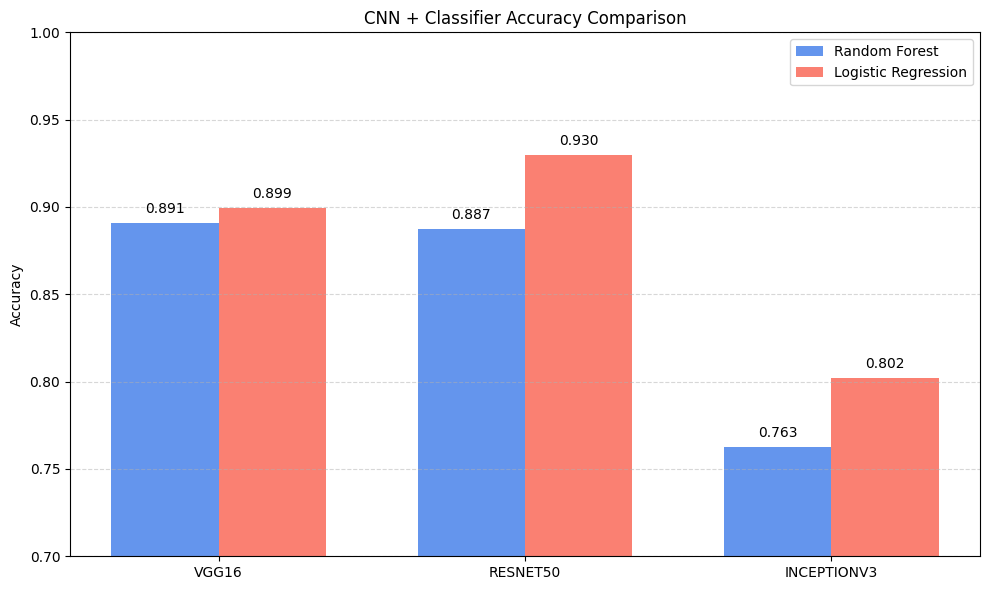

In [ ]:
models = list(accuracies.keys())
classifiers = ['random_forest', 'logistic_regression']

# Extract accuracies in the correct order
rf_scores = [accuracies[model]['random_forest'] for model in models]
lr_scores = [accuracies[model]['logistic_regression'] for model in models]

x = np.arange(len(models))  # the label locations
width = 0.35                # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest', color='cornflowerblue')
bars2 = ax.bar(x + width/2, lr_scores, width, label='Logistic Regression', color='salmon')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Accuracy')
ax.set_title('CNN + Classifier Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels([model.upper() for model in models])
ax.set_ylim(0.7, 1.0)
ax.legend()

# Annotate each bar with accuracy value
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Question 2**

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import numpy as np

In [ ]:
# Check VGG16 model summary with all the layers
vgg16_model = tf.keras.applications.VGG16(weights='imagenet',
                                       include_top=True)
vgg16_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vggModel = tf.keras.applications.VGG16(weights='imagenet',
                                       include_top=False,
                                       input_shape=(64, 64, 3))
print(vggModel.summary())
vggModel.trainable = False

model = tf.keras.models.Sequential()
model.add(vggModel)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
print(model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,802 (58.14 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


**Phase A**

Train only the new added fully connected layer

In [ ]:
trainX.shape

(19200, 64, 64, 3)

In [ ]:
trainY.shape

(19200,)

In [ ]:
NUM_EPOCHS = 25

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate =0.001),
              metrics=['accuracy'])

phaseA_model = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.6752 - loss: 4.4472 - val_accuracy: 0.8450 - val_loss: 0.5130
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.8067 - loss: 0.7944 - val_accuracy: 0.8606 - val_loss: 0.4987
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.8337 - loss: 0.7023 - val_accuracy: 0.8694 - val_loss: 0.4493
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8463 - loss: 0.6299 - val_accuracy: 0.8665 - val_loss: 0.4798
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.8541 - loss: 0.6279 - val_accuracy: 0.8712 - val_loss: 0.4686
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.8533 - loss: 0.6018 - val_accuracy: 0.8808 - val_loss: 0.4645
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8697 - loss: 0.5882 - val_accuracy: 0.8783 - val_loss: 0.4492
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8759 - loss: 0.5288 - 

In [ ]:
print(phaseA_model.history)

{'accuracy': [0.7400521039962769, 0.813072919845581, 0.8334895968437195, 0.8478124737739563, 0.8541145920753479, 0.859375, 0.8651562333106995, 0.8692187666893005, 0.8746353983879089, 0.8748958110809326, 0.8797916769981384, 0.8861979246139526, 0.8853645920753479, 0.8872395753860474, 0.8890625238418579, 0.8904687762260437, 0.893958330154419, 0.8957812786102295, 0.8979687690734863, 0.8967708349227905, 0.8965625166893005, 0.8992708325386047, 0.8992708325386047, 0.9034374952316284, 0.9032291769981384], 'loss': [2.2476727962493896, 0.788500964641571, 0.6981040239334106, 0.6449535489082336, 0.6245677471160889, 0.5989455580711365, 0.5874904990196228, 0.5602248907089233, 0.542841911315918, 0.5523533225059509, 0.5436686277389526, 0.5256879329681396, 0.5326573252677917, 0.5281352400779724, 0.5227921009063721, 0.5137591361999512, 0.48553523421287537, 0.4830249547958374, 0.4696198105812073, 0.48856258392333984, 0.48250916600227356, 0.48681095242500305, 0.46793338656425476, 0.4514400362968445, 0.484

In [ ]:
def plot_accuracy(model_result):
  accuracy = model_result.history["accuracy"]
  val_accuracy = model_result.history["val_accuracy"]
  loss = model_result.history["loss"]
  val_loss = model_result.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)

  fig, ax1 = plt.subplots(figsize=(10, 6))

  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Accuracy", color="tab:blue")
  ax1.plot(epochs, accuracy, label="Training Accuracy", color="tab:blue", linestyle="-")
  ax1.plot(epochs, val_accuracy, label="Validation Accuracy", color="tab:blue", linestyle="--")
  ax1.tick_params(axis="y", labelcolor="tab:blue")

  ax2 = ax1.twinx()
  ax2.set_ylabel("Loss", color="tab:red")
  ax2.plot(epochs, loss, label="Training Loss", color="tab:red", linestyle="-")
  ax2.plot(epochs, val_loss, label="Validation Loss", color="tab:red", linestyle="--")
  ax2.tick_params(axis="y", labelcolor="tab:red")


  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

  plt.title("Training and Validation Accuracy & Loss")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

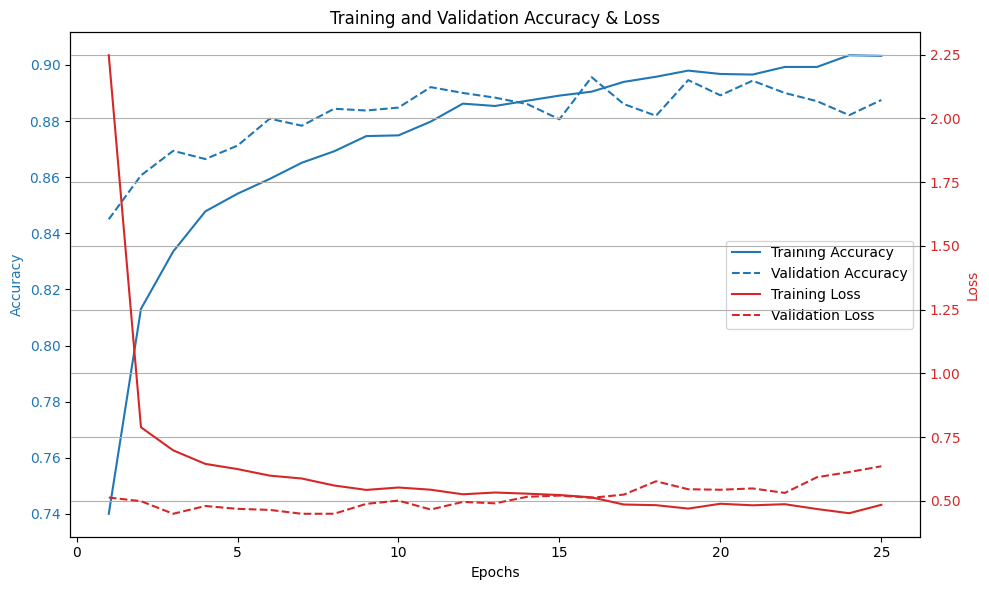

In [ ]:
plot_accuracy(phaseA_model)

**Phase B**

Unfreeze some convolutional layers

In [ ]:
vggModel.trainable = True
trainableFlag = False

for layer in vggModel.layers:
  if layer.name == 'block5_conv1': # block5_conv1
    trainableFlag = True
  layer.trainable = trainableFlag

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,768,918 (60.15 MB)

 Trainable params: 7,606,538 (29.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 527,116 (2.01 MB)

None


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

phaseB_model1 = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9094 - loss: 0.4103 - val_accuracy: 0.8992 - val_loss: 0.5120
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9278 - loss: 0.2962 - val_accuracy: 0.9062 - val_loss: 0.4906
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9408 - loss: 0.2557 - val_accuracy: 0.9123 - val_loss: 0.5468
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9459 - loss: 0.2439 - val_accuracy: 0.9194 - val_loss: 0.4609
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9479 - loss: 0.2040 - val_accuracy: 0.9192 - val_loss: 0.4308
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9581 - loss: 0.1899 - val_accuracy: 0.9242 - val_loss: 0.4383
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9594 - loss: 0.1583 - val_accuracy: 0.9269 - val_loss: 0.4187
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9647 - loss: 0.1437 - 

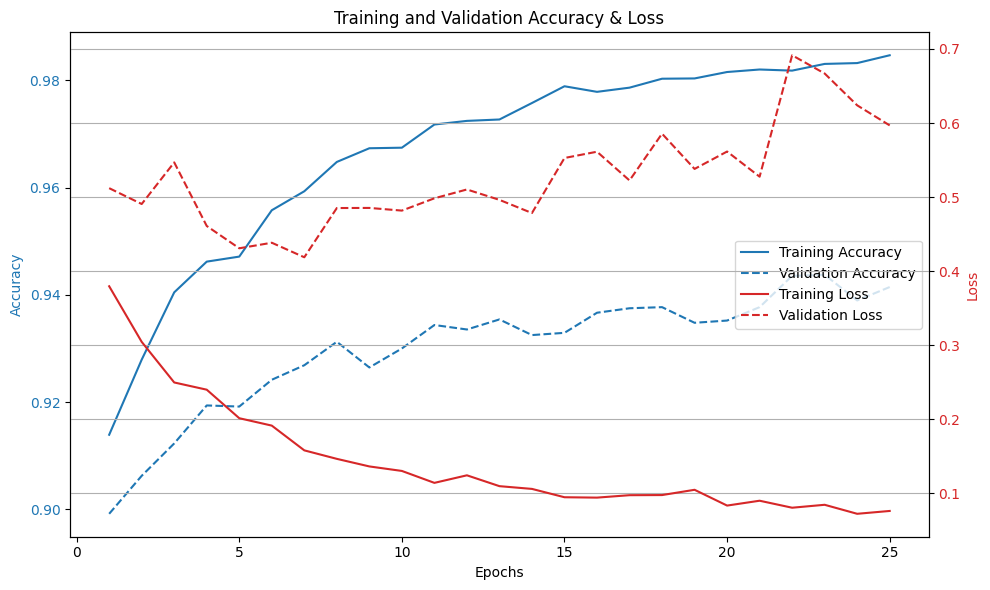

In [ ]:
plot_accuracy(phaseB_model1)

In [ ]:
vggModel.trainable = True
trainableFlag = False

for layer in vggModel.layers:
  if layer.name == 'block4_conv1':
    trainableFlag = True
  layer.trainable = trainableFlag

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,848,342 (87.16 MB)

 Trainable params: 13,506,314 (51.52 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 7,606,540 (29.02 MB)

None


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

phaseB_model2 = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.9656 - loss: 0.1687 - val_accuracy: 0.9250 - val_loss: 0.7668
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9665 - loss: 0.1685 - val_accuracy: 0.9358 - val_loss: 0.5824
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.9662 - loss: 0.1538 - val_accuracy: 0.9283 - val_loss: 0.7734
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.9739 - loss: 0.1362 - val_accuracy: 0.9406 - val_loss: 0.6239
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9783 - loss: 0.1126 - val_accuracy: 0.9467 - val_loss: 0.4194
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.9784 - loss: 0.1160 - val_accuracy: 0.9483 - val_loss: 0.5050
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9798 - loss: 0.0916 - val_accuracy: 0.9450 - val_loss: 0.3924
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.9753 - loss: 0.1172 - 

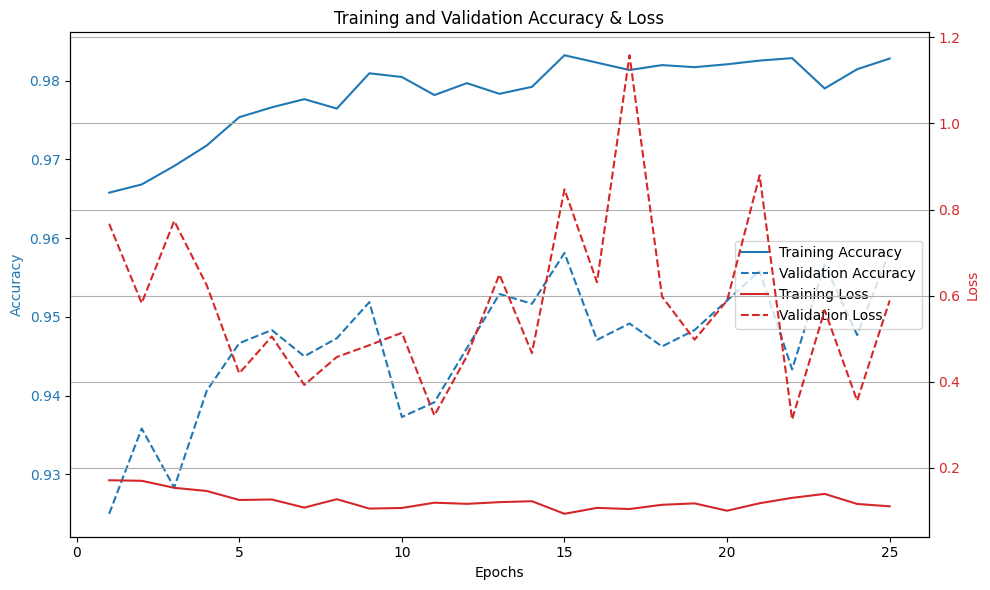

In [ ]:
plot_accuracy(phaseB_model2)

**PhaseA - With data augmentation - Adam**

In [ ]:
# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Load base VGG16 without top layers and freeze it
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(64, 64, 3), weights='imagenet')
base_model.trainable = False  # Freeze weights

# Create full model with data augmentation
inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)  # Apply augmentation
x = tf.keras.applications.vgg16.preprocess_input(x)  # Preprocess for VGG16
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)
model.name = "VGG16-With-Augmentation"

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "VGG16-With-Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 64, 64, 3) │          0 │ input_layer_19[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 64, 64)    │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 64, 64)    │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 64, 64)    │          0 │ sequential_6[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_15[0][0… │
│                     │                   │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 64, 64, 3) │          0 │ stack_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 2, 2, 512) │ 14,714,688 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 10)        │      2,570 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
aug_model_phaseA = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6617 - loss: 2.0908 - val_accuracy: 0.8838 - val_loss: 0.3795
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8302 - loss: 0.5314 - val_accuracy: 0.8904 - val_loss: 0.3327
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8469 - loss: 0.4826 - val_accuracy: 0.8848 - val_loss: 0.3448
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8572 - loss: 0.4325 - val_accuracy: 0.8965 - val_loss: 0.3230
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8677 - loss: 0.3974 - val_accuracy: 0.8981 - val_loss: 0.3080
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8689 - loss: 0.3940 - val_accuracy: 0.9104 - val_loss: 0.2921
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8793 - loss: 0.3748 - val_accuracy: 0.9085 - val_loss: 0.2830
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8816 - loss: 0.3593 - 

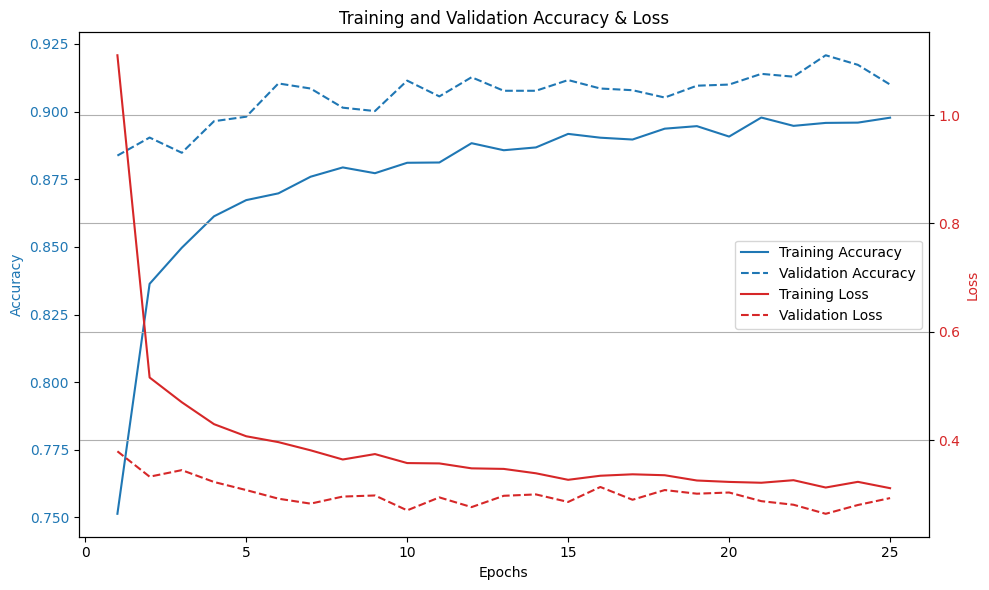

In [ ]:
plot_accuracy(aug_model_phaseA)

**PhaseB - With data augmentation - Adam**

In [ ]:
base_model.trainable = True
trainableFlag = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1': # block5_conv1
    trainableFlag = True
  layer.trainable = trainableFlag

print(model.summary())

Model: "VGG16-With-Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 64, 64, 3) │          0 │ input_layer_16[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 64, 64)    │          0 │ sequential_5[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 64, 64)    │          0 │ sequential_5[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 64, 64)    │          0 │ sequential_5[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_12[0][0… │
│                     │                   │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 64, 3) │          0 │ stack_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 2, 2, 512) │ 14,714,688 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10)        │      2,570 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,116,384 (57.66 MB)

 Trainable params: 7,213,322 (27.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 267,798 (1.02 MB)

None


In [ ]:
aug_model_phaseB = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8983 - loss: 0.3126 - val_accuracy: 0.9162 - val_loss: 0.2880
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9002 - loss: 0.3106 - val_accuracy: 0.9073 - val_loss: 0.2991
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8992 - loss: 0.3151 - val_accuracy: 0.9117 - val_loss: 0.2924
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9011 - loss: 0.3061 - val_accuracy: 0.9092 - val_loss: 0.3039
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8978 - loss: 0.3097 - val_accuracy: 0.9137 - val_loss: 0.3036
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8980 - loss: 0.3103 - val_accuracy: 0.9171 - val_loss: 0.2866
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9000 - loss: 0.3024 - val_accuracy: 0.9102 - val_loss: 0.3067
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9007 - loss: 0.3065 - 

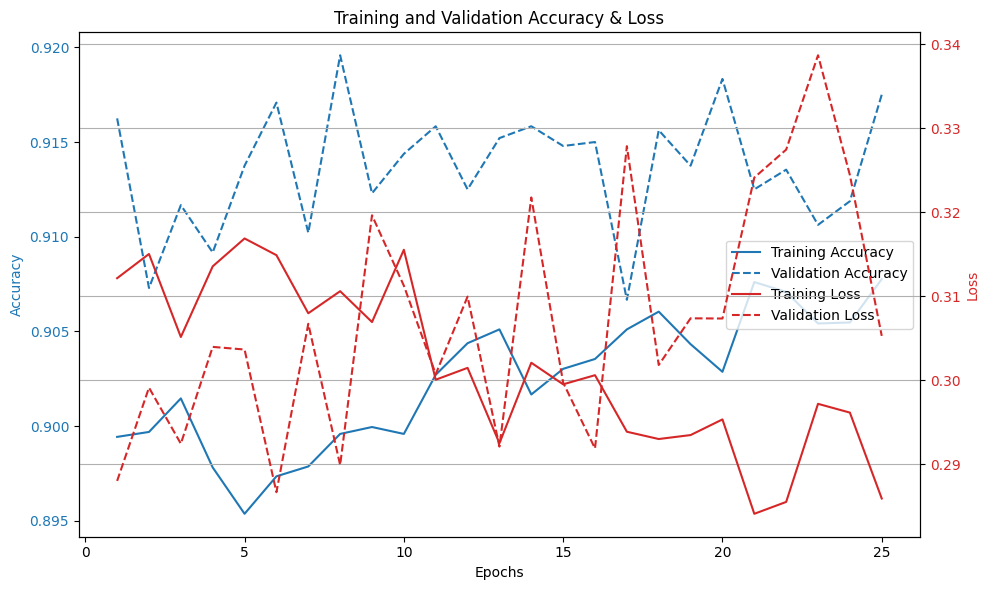

In [ ]:
plot_accuracy(aug_model_phaseB)

**PhaseA - With data augmentation - RMSprop**

In [ ]:
# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Load base VGG16 without top layers and freeze it
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(64, 64, 3), weights='imagenet')
base_model.trainable = False  # Freeze weights

inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)  # Apply augmentation
x = tf.keras.applications.vgg16.preprocess_input(x)  # Preprocess for VGG16
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)
model.name = "VGG16-With-Augmentation"

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "VGG16-With-Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64, 3) │          0 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_18[0][0… │
│                     │                   │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 64, 64, 3) │          0 │ stack_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 2, 2, 512) │ 14,714,688 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │      2,570 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
aug_rms_model_phaseA = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1374 - loss: 8.9627 - val_accuracy: 0.3735 - val_loss: 3.1148
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.2864 - loss: 5.2003 - val_accuracy: 0.5479 - val_loss: 1.9339
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.4005 - loss: 3.7402 - val_accuracy: 0.6458 - val_loss: 1.4458
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.4803 - loss: 2.9431 - val_accuracy: 0.7135 - val_loss: 1.1855
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5360 - loss: 2.4229 - val_accuracy: 0.7460 - val_loss: 1.0429
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5808 - loss: 2.1075 - val_accuracy: 0.7696 - val_loss: 0.9401
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.6181 - loss: 1.8510 - val_accuracy: 0.7840 - val_loss: 0.8656
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6381 - loss: 1.6512 - 

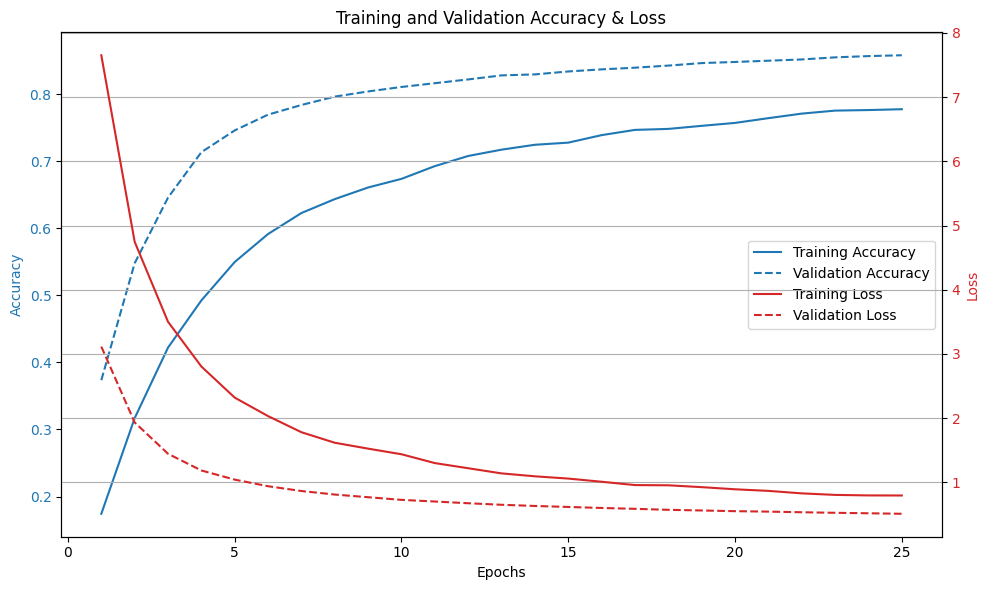

In [ ]:
plot_accuracy(aug_rms_model_phaseA)

**PhaseB - With data augmentation - RMSprop**

In [ ]:
base_model.trainable = True
trainableFlag = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1': # block5_conv1
    trainableFlag = True
  layer.trainable = trainableFlag

print(model.summary())

Model: "VGG16-With-Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64, 3) │          0 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_18[0][0… │
│                     │                   │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 64, 64, 3) │          0 │ stack_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 2, 2, 512) │ 14,714,688 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │      2,570 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,982,486 (57.15 MB)

 Trainable params: 7,213,322 (27.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 133,900 (523.05 KB)

None


In [ ]:
aug_rms_model_phaseB1 = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7723 - loss: 0.7942 - val_accuracy: 0.8575 - val_loss: 0.5062
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7891 - loss: 0.7669 - val_accuracy: 0.8592 - val_loss: 0.4988
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7886 - loss: 0.7381 - val_accuracy: 0.8619 - val_loss: 0.4957
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7935 - loss: 0.7550 - val_accuracy: 0.8629 - val_loss: 0.4899
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7961 - loss: 0.7236 - val_accuracy: 0.8629 - val_loss: 0.4854
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7982 - loss: 0.7114 - val_accuracy: 0.8637 - val_loss: 0.4800
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8014 - loss: 0.6933 - val_accuracy: 0.8662 - val_loss: 0.4755
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8025 - loss: 0.6947 - 

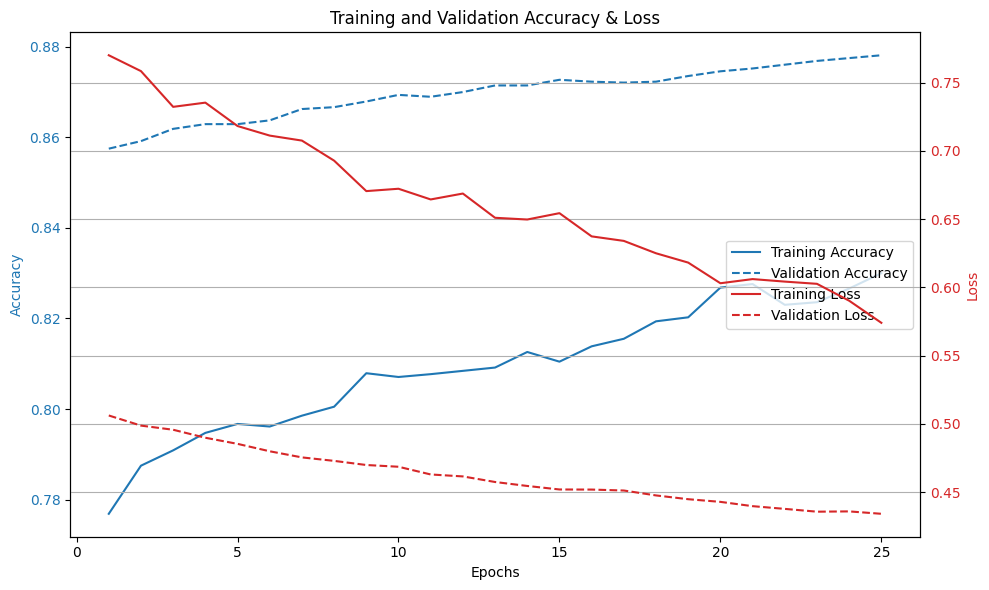

In [ ]:
plot_accuracy(aug_rms_model_phaseB1)

In [ ]:
base_model.trainable = True
trainableFlag = False

for layer in base_model.layers:
  if layer.name == 'block4_conv1':
    trainableFlag = True
  layer.trainable = trainableFlag

print(model.summary())

Model: "VGG16-With-Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64, 3) │          0 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_20         │ (None, 64, 64)    │          0 │ sequential_7[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_6 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_18[0][0… │
│                     │                   │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 64, 64, 3) │          0 │ stack_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 2, 2, 512) │ 14,714,688 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │      2,570 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,982,486 (57.15 MB)

 Trainable params: 13,113,098 (50.02 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 133,900 (523.05 KB)

None


In [ ]:
aug_rms_model_phaseB2 = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8286 - loss: 0.5885 - val_accuracy: 0.8796 - val_loss: 0.4330
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8340 - loss: 0.5700 - val_accuracy: 0.8796 - val_loss: 0.4295
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8338 - loss: 0.5772 - val_accuracy: 0.8790 - val_loss: 0.4269
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8356 - loss: 0.5713 - val_accuracy: 0.8790 - val_loss: 0.4265
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8329 - loss: 0.5908 - val_accuracy: 0.8806 - val_loss: 0.4240
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8319 - loss: 0.5661 - val_accuracy: 0.8800 - val_loss: 0.4244
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8360 - loss: 0.5648 - val_accuracy: 0.8802 - val_loss: 0.4250
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8431 - loss: 0.5501 - 

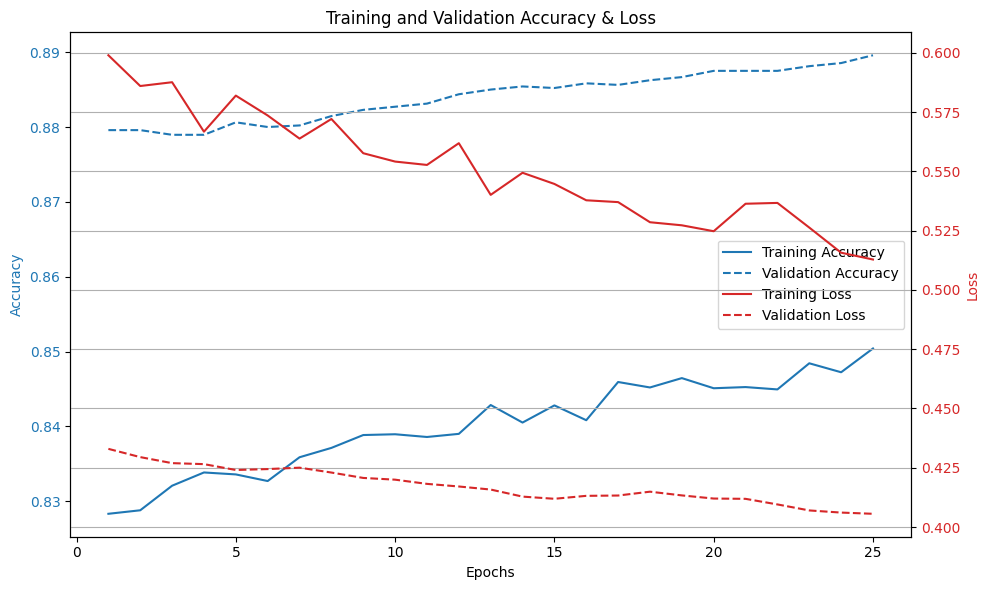

In [ ]:
plot_accuracy(aug_rms_model_phaseB2)

In [ ]:
aug_rms_model_phaseB2_1 = model.fit(trainX, trainY,
                         epochs=50, # Increase the number of epochs from 30 to 50
                         batch_size=32,
                         validation_data=(valX, valY))

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8530 - loss: 0.5204 - val_accuracy: 0.8883 - val_loss: 0.4047
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8471 - loss: 0.5322 - val_accuracy: 0.8890 - val_loss: 0.4044
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8430 - loss: 0.5181 - val_accuracy: 0.8896 - val_loss: 0.4042
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8540 - loss: 0.5080 - val_accuracy: 0.8888 - val_loss: 0.4028
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8580 - loss: 0.4900 - val_accuracy: 0.8888 - val_loss: 0.4022
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8539 - loss: 0.4950 - val_accuracy: 0.8898 - val_loss: 0.4009
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8519 - loss: 0.5066 - val_accuracy: 0.8896 - val_loss: 0.3996
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8556 - loss: 0.5033 - 

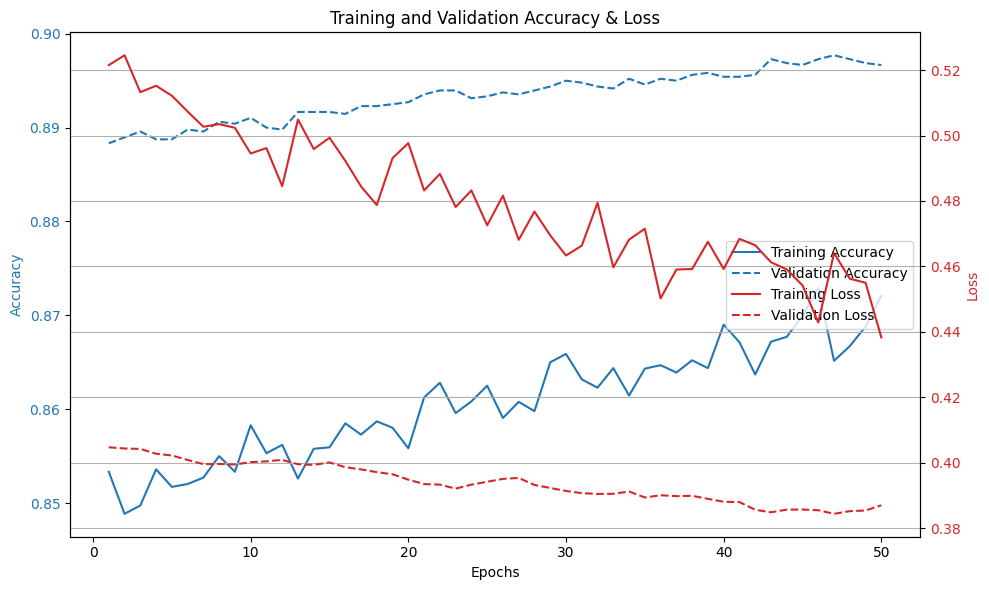

In [ ]:
plot_accuracy(aug_rms_model_phaseB2_1)

# **Using ResNet50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
print(base_model.summary())
base_model.trainable = False  # Freeze weights

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 64, 64, 3) │          0 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 64, 64)    │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 64, 64)    │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 64, 64)    │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 64, 64, 3) │          0 │ get_item_6[0][0], │
│                     │                   │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64, 3) │          0 │ stack_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2, 2,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │      2,570 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Phase A**

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 389s 631ms/step - accuracy: 0.2175 - loss: 3.2155 - val_accuracy: 0.7244 - val_loss: 0.9215
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 374s 618ms/step - accuracy: 0.5683 - loss: 1.4408 - val_accuracy: 0.8190 - val_loss: 0.6120
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 381s 617ms/step - accuracy: 0.6926 - loss: 1.0017 - val_accuracy: 0.8448 - val_loss: 0.5094
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 374s 624ms/step - accuracy: 0.7475 - loss: 0.8117 - val_accuracy: 0.8610 - val_loss: 0.4558
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 363s 592ms/step - accuracy: 0.7698 - loss: 0.7534 - val_accuracy: 0.8723 - val_loss: 0.4207
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 385s 596ms/step - accuracy: 0.7895 - loss: 0.6776 - val_accuracy: 0.8781 - val_loss: 0.3970
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 393s 615ms/step - accuracy: 0.7969 - loss: 0.6371 - val_accuracy: 0.8802 - val_loss: 0.3806
Epoch 8/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 382s 615ms/step - accuracy: 0.8166 -

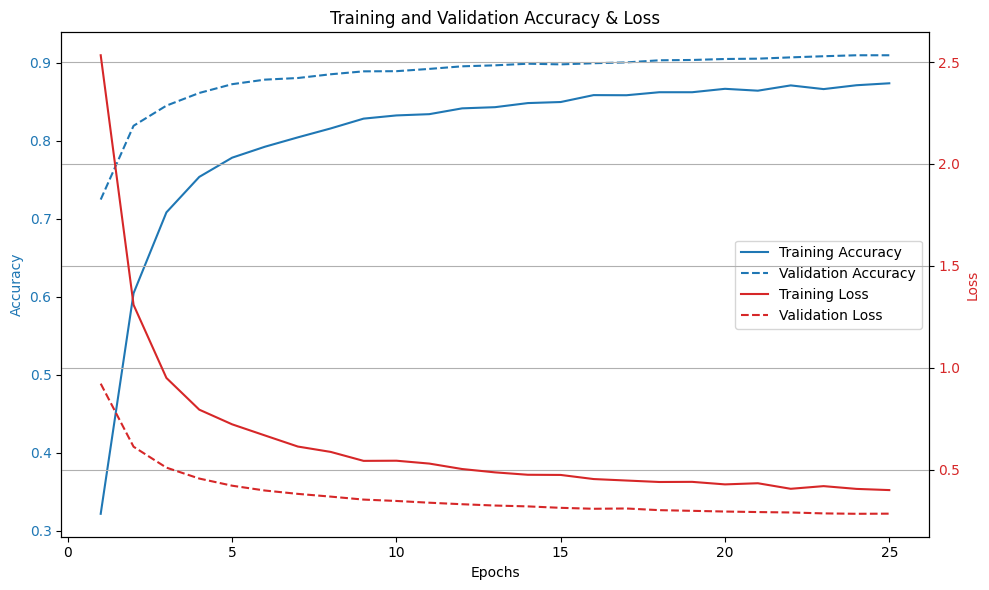

In [ ]:
resnet50_phaseA = model.fit(trainX, trainY,
                         epochs=NUM_EPOCHS,
                         batch_size=32,
                         validation_data=(valX, valY))
plot_accuracy(resnet50_phaseA)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras import layers, models

# Choose one of the base models
def get_base_model(name="VGG16", input_shape=(224, 224, 3)):
    if name == "VGG16":
        return VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name == "ResNet50":
        return ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name == "InceptionV3":
        input_shape = (299, 299, 3)  # InceptionV3 expects 299x299
        return InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Model name not recognized.")

# Data Augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

# Build the complete model
def build_transfer_model(base_model_name="VGG16", num_classes=10):
    input_shape = (299, 299, 3) if base_model_name == "InceptionV3" else (224, 224, 3)
    base_model = get_base_model(base_model_name, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Preprocessing specific to each model
    if base_model_name == "VGG16":
        x = tf.keras.applications.vgg16.preprocess_input(x)
    elif base_model_name == "ResNet50":
        x = tf.keras.applications.resnet.preprocess_input(x)
    elif base_model_name == "InceptionV3":
        x = tf.keras.applications.inception_v3.preprocess_input(x)

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Example usage
model_vgg = build_transfer_model("VGG16", num_classes=10)
model_resnet = build_transfer_model("ResNet50", num_classes=10)
model_inception = build_transfer_model("InceptionV3", num_classes=10)

# Now you can train using model.fit(train_ds, validation_data=val_ds, ...